# Data Loading

In [214]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/MyDrive/Senior/Spring/EC523/FinalProject/ec523/data.zip
!unzip /content/drive/MyDrive/School/Graduate/Classes/2024\ Spring/EC523\ Deep\ Learning/data.zip


# Data Pre-Processing (Haar classifier, normalization, etc.)

In [344]:
import os

import cv2
import tensorflow as tf

# Unique syllable tokens in LipNet dataset
tokens = ['a', 'again', 'at', 'b', 'bin', 'blue', 'by', 'c', 'd', 'e', 'eight',
          'f', 'five', 'four', 'g', 'green', 'h', 'i', 'in', 'j', 'k', 'l',
          'lay', 'm', 'n', 'nine', 'now', 'o', 'one', 'p', 'place', 'please',
          'q', 'r', 'red', 's', 'set', 'seven', 'sil', 'six', 'soon', 'sp', 't',
          'three', 'two', 'u', 'v', 'white', 'with', 'x', 'y', 'z', 'zero']


def process_video_file(path: str):
    """
    Images are now fully pre-processed here before being stored or saved.
    """

    # Load video
    cap = cv2.VideoCapture(path)  # e.g. /content/data/videos/bbaf2n.mpg

    frame_count = 0
    # processed_frames = []
    tensors_list = []

    while True:

        # Read frame from vid
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grey scale
        # gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = frame  # TODO: Temporarily testing with color images

        # Lip detection
        for x in reversed(range(5, 8)):  # lower conditions as needed to find best match
            lips = lip_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=x, minSize=(60, 30), maxSize=(120, 60))
            if len(lips) > 0:
                break
        if len(lips) == 0:  # if still no match, use static vals
            lips = [[50, 150, 200, 100]]
        (x, y, w, h) = lips[0]
        # print(f'{frame_count:02d}', ': ', lips[0])

        # Store normalized, grayscaled, and uniformly cropped
        gray_normal_crop = cv2.normalize(gray, gray, 0, 100, cv2.NORM_MINMAX)[y:y+h, x:x+w]
        final_img = cv2.resize(gray_normal_crop, (80, 40))
        tensors_list.append(final_img)

        # Save to file
        # cv2.imwrite(os.path.join(output_dir, f'frame_{frame_count}.jpg'), final_img)

        # Save some of the color images with the bounding box...
        # if frame_count == 10:
        #     cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 200, 0), 2)  # draws rectangle
        #     cv2.imwrite(os.path.join(output_dir, f'frame_{frame_count}.jpg'), frame)

        frame_count += 1

    # TODO: tf.normalize across all images?
    # mean = tf.math.reduce_mean(processed_frames)
    # std = tf.math.reduce_std(tf.cast(processed_frames, tf.float32))
    # processed_frames.append(cv2.normalize(gray, gray, 0, 100, cv2.NORM_MINMAX)[y:y+h, x:x+w])
    # processed_frames = (tf.cast((processed_frames - mean), tf.float32) / std).numpy()
    # for i, v in enumerate(processed_frames):
    #     output_path = os.path.join(output_dir, f"frame_{i}.jpg")
    #     cv2.imwrite(output_path, v)
    # print(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))  # number of frames in video

    cap.release()

    # print(f"Finished processing video; {frame_count} frames saved in:", output_dir)
    # print(f'\nvideo_tensor ({type(video_tensor)}, {video_tensor.shape}): \n', video_tensor)

    return np.array(tensors_list)


# Load annotations
def load_annotations(annotation_file: str) -> list[str]:

    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        annotations = [line.strip().split() for line in lines]

    return annotations


def process_annotations_file(path: str):
    """
    Should experiment with syllable labels vs. video labels...
    """

    # annotation_file = "/content/data/annotations/s1/bbaf2n.align"
    annotations = load_annotations(path)

    # Map frames to annotations based on filename; each annotation line contains:
    # [<start of syllable to thousandth of a frame>,
    #    <end of syllable to thousandth of a frame>,
    #    <syllable/annotation>]
    # frame_labels = []
    video_label = ''
    for line in annotations:
        # rng = np.array([int(line[0]), int(line[1])]) // 1000
        # frame_labels[rng[0]:rng[1] + 1] = [line[2]] * ((rng[1] + 1) - rng[0])

        # for letter in line[2]:
        #     video_label.append(ord(letter) - 97)

        token = line[2]
        # video_label.append(next(i for i, v in enumerate(tokens) if v == token))
        video_label += token

    # print(f'\nannotated_frames ({(cnt := len(frame_labels))}): \n', frame_labels)
    # print(f'\nvideo_label ({len(video_label)}, {type(video_label)}): \n', video_label)

    # Tests (for bbaf2n)
    # assert cnt == frame_count
    # assert frame_labels[33] == 'blue' and frame_labels[34]      == 'at'
    # assert frame_labels[0]  == 'sil'  and frame_labels[cnt - 1] == 'sil'
    # assert video_label[0]   == 18     and video_label[3]        == 1

    # TODO: Remove 'sil' (i.e. silence) frames?

    return video_label


In [363]:
import os

import cv2
import tensorflow as tf

# Directory to store processed frames
output_dir = "/content/processed_frames"
os.makedirs(output_dir, exist_ok=True)

# Directories for videos and annotations
videos_dir = '/content/data/videos'
annotations_dir = '/content/data/annotations/s1'

# Set limit to 0 to remove limit and use all videos
video_limit = 10  # On Google Colab Pro, 100 takes about ~6 mins to load

# Use Haar cascade for lip detection
lip_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

# Loop over files, loading images and labels
inputs = []
labels = []
for i, annotations_name in enumerate(os.listdir(annotations_dir)):
    if i > video_limit and video_limit > 0:
        break
    name = annotations_name.split('.')[0]

    # TODO: Best to treat video label as a single categorical label, or label by syllable?
    labels.append(len(labels))
    # labels.append(process_annotations_file(f'{annotations_dir}/{annotations_name}'))

    input = process_video_file(f'{videos_dir}/{name}.mpg')
    inputs.append(input)

    print(i, ': ', name, input.shape)

inputs = np.array(inputs)
labels = np.array(labels)

print(f'\ninputs ({inputs.shape}): \n')#, inputs)
print(f'\nlabels ({labels.shape}): \n')#, labels)


0 :  bwwu2p (75, 40, 80, 3)
1 :  lrid8n (75, 40, 80, 3)
2 :  sriuzp (75, 40, 80, 3)
3 :  pbib9a (75, 40, 80, 3)
4 :  lgiz4p (75, 40, 80, 3)
5 :  bwig1s (75, 40, 80, 3)
6 :  sgiczp (75, 40, 80, 3)
7 :  srwvzn (75, 40, 80, 3)
8 :  bwam9s (75, 40, 80, 3)
9 :  lgbs7s (75, 40, 80, 3)
10 :  pbwp9a (75, 40, 80, 3)

inputs ((11, 75, 40, 80, 3)): 


labels ((11,)): 



# Model Creation

In [362]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(inputs, labels, test_size=0.2, random_state=42)

print(f'\nX_train {X_train.shape}: \n')#, X_train)
print(f'\nX_val   {X_val.shape}:   \n')#, X_val)
print(f'\ny_train {y_train.shape}: \n')#, y_train)
print(f'\ny_val   {y_val.shape}:   \n')#, y_val)



X_train (32, 75, 40, 80, 3): 


X_val   (9, 75, 40, 80, 3):   


y_train (32,): 


y_val   (9,):   



In [359]:
"""
TODO: Need to experiment with different kernel size, adding dropout, regularization, etc.

Document clearly; such testing can be a part of the final submission.

"""

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical

# Define width, height, and number of frames
width      = 80  # originally 224
height     = 40  # originally 224
num_frames = 75  # Number of frames per video (currently using all frames)
channels   = 3

# Calculate the number of unique classes or labels
num_classes = len(labels)

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes)
y_val_encoded   = to_categorical(y_val,   num_classes)

# Define the lip reading model architecture
model = models.Sequential([
    # 3D Convolutional layers
    layers.Conv3D(32,   (3, 3, 3), activation='relu', padding='same', input_shape=(num_frames, height, width, channels)),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(64,   (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D((2, 2, 2)),
    layers.Conv3D(128,  (3, 3, 3), activation='relu', padding='same'),
    layers.MaxPooling3D((1, 2, 2)),  # Adjusted pooling size

    # Flatten layer
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_66 (Conv3D)          (None, 75, 40, 80, 32)    2624      
                                                                 
 max_pooling3d_66 (MaxPooli  (None, 37, 20, 40, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_67 (Conv3D)          (None, 37, 20, 40, 64)    55360     
                                                                 
 max_pooling3d_67 (MaxPooli  (None, 18, 10, 20, 64)    0         
 ng3D)                                                           
                                                                 
 conv3d_68 (Conv3D)          (None, 18, 10, 20, 128)   221312    
                                                                 
 max_pooling3d_68 (MaxPooli  (None, 18, 5, 10, 128)  

# Model Training and Testing

Epoch 1/10
4/4 [==============================] - 66s 15s/step - loss: 3.6801 - accuracy: 0.0625 - val_loss: 3.8474 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 65s 15s/step - loss: 3.6236 - accuracy: 0.1250 - val_loss: 4.1982 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 69s 16s/step - loss: 3.6002 - accuracy: 0.0312 - val_loss: 4.3638 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 62s 15s/step - loss: 3.4426 - accuracy: 0.0312 - val_loss: 4.1334 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 69s 17s/step - loss: 3.4221 - accuracy: 0.0938 - val_loss: 5.5126 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 64s 16s/step - loss: 3.2674 - accuracy: 0.1562 - val_loss: 4.3061 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 74s 18s/step - loss: 3.1927 - accuracy: 0.2812 - val_loss: 5.2642 - val_accuracy: 0.0000e+00

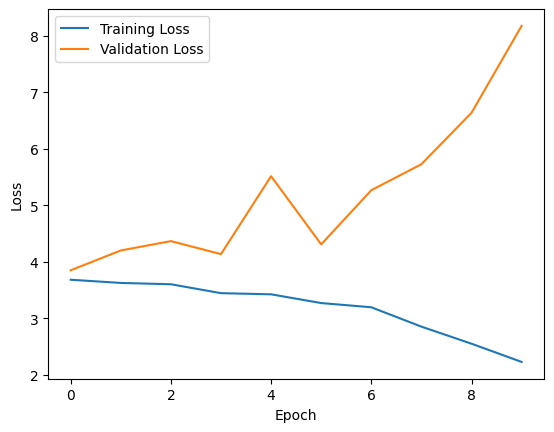

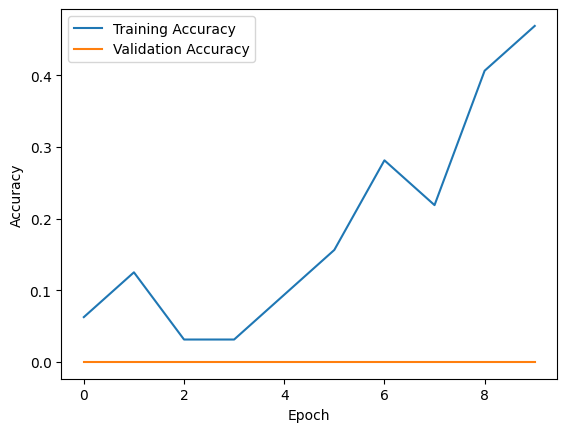

In [361]:
"""
TODO: Experiment with fine-tuning batch_size, etc.

Document clearly; such testing can be a part of the final submission.

"""

import matplotlib.pyplot as plt

# train model using your processed frames as input data
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=10, validation_data=(X_val, y_val_encoded))

# model performance
loss, accuracy = model.evaluate(X_val, y_val_encoded)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# TODO: Option to print actual model estimate (syllable sequence for that video)


In [ ]:
# TODO: Implement...

%load_ext tensorboard
%tensorboard --logdir logs

import visualkeras

visualkeras.layered_view(model).show()

# Old Cells

In [327]:
"""
Now being handled above; kept cell for future reference
"""

import os

import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical

# Generate list of unique tokens (i.e. syllables)
# temp_labels = []
# for i, annotations_name in enumerate(os.listdir(annotations_dir)):
#     if annotations_name.endswith('.align'):
#         annotations = load_annotations(f'{annotations_dir}/{annotations_name}')
#         for line in annotations:
#             if line[2] not in temp_labels:
#                 temp_labels.append(line[2])
# print(sorted(temp_labels))


# extract label from filename
def extract_label(filename):
    label = filename.split("_")[1].split(".")[0]  # labels are now defined above
    return label


# Function to load and preprocess frames
# (Now being handled above, before the images are saved, to reduce space)
def load_and_preprocess_frames(directory):
    frames = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            # load the frame
            img = cv2.imread(os.path.join(directory, filename))
            # preprocess frame (resize, normalize, etc.)
            img = cv2.resize(img, (width, height))  # resize frame
            img = img / 255.0  # normalize pixel values to [0, 1]
            # append the frame and label
            frames.append(img)
            labels.append(extract_label(filename))  # extract label

    return np.array(labels)#, np.array(frames)


# Load and preprocess frames
# labels = load_and_preprocess_frames("/content/processed_frames")
# print(labels)
